In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load all data sheets
excel_path = 'dataset/LTCM_database.xlsx'
dfs = pd.read_excel(excel_path, sheet_name=None)

# Create dataframe with all time series
data_dict = {}

for sheet, df in dfs.items():
    if sheet.strip().lower() == 'master list':
        continue
    
    # Rename columns for consistency
    df.columns = [col.strip().lower() for col in df.columns]
    date_col = df.columns[0]
    
    # Parse dates
    df[date_col] = pd.to_datetime(df[date_col], format='%m/%d/%Y', errors='coerce')
    df = df.dropna(subset=[date_col])
    df = df.sort_values(by=date_col)
    df = df.set_index(date_col)
    
    # Store with clean name
    clean_name = sheet.strip()
    data_dict[clean_name] = df.iloc[:, 0]

# Merge all into one dataframe
df_master = pd.DataFrame(data_dict)
print(f"Data loaded: {df_master.shape[0]} dates, {df_master.shape[1]} series")
print(f"Date range: {df_master.index.min()} to {df_master.index.max()}")
print(f"\nAvailable series:\n{df_master.columns.tolist()}")

Data loaded: 17329 dates, 19 series
Date range: 1920-02-27 00:00:00 to 2025-10-23 00:00:00

Available series:
['Fed Target Inflation', 'Labor Market Health', 'Monetary Policy', 'US GDP', 'Inflation Expectations', 'Core Inflation', 'Credit Spread Risk', 'Volatility Index', 'Gold Commodity', 'RUBUSD', 'Bloomberg US Aggregate Total Re', 'Bloomberg U.S. Treasury  20+ Ye', 'Swap Spread', 'US Treasury 10-Year Yield', 'US Treasury 5-Year Yield', 'US Treasury 2-Year Yield', 'JPMorgan EMBI Global Diversifie', 'Merrill Lynch Option Volatility', 'US Treasury 3-Month Yield']


## Calculate Spreads and Returns

### Arbitrage Spreads Calculation

In [3]:
# Filter data for LTCM period (1995-1998)
ltcm_period = (df_master.index >= '1995-01-01') & (df_master.index <= '1998-12-31')
df_ltcm = df_master[ltcm_period].copy()

print(f"LTCM Period: {df_ltcm.index.min()} to {df_ltcm.index.max()}")
print(f"Total observations: {len(df_ltcm)}")

# Calculate daily returns for all relevant series
# For fixed income, we use price indices or approximate returns from yield changes
returns_series = {}

# 1. Credit Spread Return - using Bloomberg Aggregate (bond index)
returns_series['R_credit'] = df_ltcm['Bloomberg US Aggregate Total Re'].pct_change()

# 2. Treasury Return - using 20+ Year Treasury index (for duration exposure)
returns_series['R_treasury'] = df_ltcm['Bloomberg U.S. Treasury  20+ Ye'].pct_change()

# 3. Emerging Markets Return
returns_series['R_em'] = df_ltcm['JPMorgan EMBI Global Diversifie'].pct_change()

# 4. Volatility exposure (LTCM also traded volatility)
returns_series['R_vol'] = df_ltcm['Volatility Index'].pct_change()

# Risk-free rate (3-month Treasury) - convert annual to daily
returns_series['R_f'] = df_ltcm['US Treasury 3-Month Yield'] / 100 / 252

# Create returns dataframe and remove NaN
df_returns = pd.DataFrame(returns_series).dropna()

print(f"\nReturns calculated: {len(df_returns)} daily observations")
print(f"\nReturns summary statistics:")
print(df_returns[['R_credit', 'R_treasury', 'R_em', 'R_vol']].describe())

LTCM Period: 1995-01-02 00:00:00 to 1998-12-31 00:00:00
Total observations: 1058

Returns calculated: 1011 daily observations

Returns summary statistics:
          R_credit   R_treasury         R_em        R_vol
count  1011.000000  1011.000000  1011.000000  1011.000000
mean      0.000393     0.000583     0.000660     0.001244
std       0.002465     0.005778     0.010450     0.055404
min      -0.015553    -0.032846    -0.088850    -0.176152
25%      -0.000937    -0.002516    -0.002749    -0.032638
50%       0.000243     0.000331     0.001013     0.000000
75%       0.001779     0.003943     0.005005     0.028671
max       0.010718     0.019935     0.091808     0.343116


### Define the Leveraged Portfolio (The LTCM Bet)

**Portfolio Weights (Market-Neutral Convergence Strategy based on data for LTCM):**
- Long Credit (Bloomberg Aggregate): 50%
- Short Treasury (20+ Year): -30%
- Long Emerging Markets (EMBI): 30%
- Short Volatility (VIX): -50%
- **Leverage: L = 25x**


In [4]:
# Define portfolio weights (Market-neutral convergence strategy)
# LTCM strategy: Long credit/EM, Short treasuries, Short volatility
w_credit = 0.50      # Long credit (aggregate bonds)
w_treasury = -0.30   # Short treasuries (negative weight)
w_em = 0.30         # Long emerging markets
w_vol = -0.50        # Short volatility
L = 25  # Leverage ratio

# Calculate unleveraged portfolio return
df_returns['R_p'] = (w_credit * df_returns['R_credit'] + 
                     w_treasury * df_returns['R_treasury'] + 
                     w_em * df_returns['R_em'] +
                     w_vol * df_returns['R_vol'])

# Calculate leveraged portfolio return
# R_p,L = L * R_p - (L - 1) * R_f
df_returns['R_p_L'] = L * df_returns['R_p'] - (L - 1) * df_returns['R_f']

print("="*60)
print("Leveraged portfolio statistics")
print("="*60)
print(f"\nPortfolio Weights:")
print(f"  Credit (Bloomberg Aggregate): {w_credit*100:+.0f}%")
print(f"  Treasury (20+ Year): {w_treasury*100:+.0f}%")
print(f"  Emerging Markets: {w_em*100:+.0f}%")
print(f"  Volatility: {w_vol*100:+.0f}%")
print(f"  Leverage: {L}x")
print(f"\nLeveraged Portfolio Returns (R_p,L):")
print(f"  Mean Daily Return: {df_returns['R_p_L'].mean()*100:.4f}%")
print(f"  Std Deviation: {df_returns['R_p_L'].std()*100:.4f}%")
print(f"  Skewness: {df_returns['R_p_L'].skew():.4f}")
print(f"  Kurtosis: {df_returns['R_p_L'].kurtosis():.4f}")
print(f"  Min Return: {df_returns['R_p_L'].min()*100:.4f}%")
print(f"  Max Return: {df_returns['R_p_L'].max()*100:.4f}%")
print("="*60)

Leveraged portfolio statistics

Portfolio Weights:
  Credit (Bloomberg Aggregate): +50%
  Treasury (20+ Year): -30%
  Emerging Markets: +30%
  Volatility: -50%
  Leverage: 25x

Leveraged Portfolio Returns (R_p,L):
  Mean Daily Return: -1.5499%
  Std Deviation: 72.1718%
  Skewness: -0.9040
  Kurtosis: 3.7565
  Min Return: -482.8388%
  Max Return: 247.1039%


## Risk Modeling and Comparative Analysis

### The Flawed Normal Distribution (LTCM's Mistake)

In [5]:
# Model 1: Parametric VaR assuming Normal Distribution
alpha = 0.99  # 99% confidence level
z_alpha = stats.norm.ppf(1 - alpha)  # Z-score for 99% (left tail)

# Calculate mean and std
mu = df_returns['R_p_L'].mean()
sigma = df_returns['R_p_L'].std()

# Parametric VaR (Normal)
VaR_normal = abs(mu + sigma * z_alpha)

# Parametric CVaR (Normal) - Expected Shortfall
CVaR_normal = abs(mu + sigma * (np.exp(-z_alpha**2 / 2) / (np.sqrt(2 * np.pi) * (1 - alpha))))

print("="*60)
print("MODEL 1: PARAMETRIC VAR (NORMAL DISTRIBUTION)")
print("="*60)
print(f"Confidence Level: {alpha*100}%")
print(f"Mean (μ): {mu*100:.4f}%")
print(f"Std Dev (σ): {sigma*100:.4f}%")
print(f"Z-score: {z_alpha:.4f}")
print(f"\nVaR (Normal): {VaR_normal*100:.4f}%")
print(f"CVaR (Normal): {CVaR_normal*100:.4f}%")
print("="*60)

MODEL 1: PARAMETRIC VAR (NORMAL DISTRIBUTION)
Confidence Level: 99.0%
Mean (μ): -1.5499%
Std Dev (σ): 72.1718%
Z-score: -2.3263

VaR (Normal): 169.4465%
CVaR (Normal): 190.8033%


### Monte Carlo with Fat-Tail Distribution (Student's t)

In [6]:
# Model 2: Fit Student's t-distribution and run Monte Carlo simulation
returns_data = df_returns['R_p_L'].dropna().values

# Fit Student's t-distribution
params = stats.t.fit(returns_data)
nu = params[0]       # Degrees of freedom
loc = params[1]      # Location parameter
scale = params[2]    # Scale parameter

print("="*60)
print("MODEL 2: MONTE CARLO WITH STUDENT'S T-DISTRIBUTION")
print("="*60)
print(f"Fitted Parameters:")
print(f"  Degrees of Freedom (ν): {nu:.4f}")
print(f"  Location (μ): {loc*100:.4f}%")
print(f"  Scale (σ): {scale*100:.4f}%")
print(f"\nNote: Lower ν indicates fatter tails (ν=∞ → Normal)")

# Monte Carlo Simulation (100,000 paths)
np.random.seed(42)
n_simulations = 100000

returns_sim = stats.t.rvs(nu, loc=loc, scale=scale, size=n_simulations)

# Calculate VaR and CVaR from simulation
VaR_t_mc = abs(np.percentile(returns_sim, (1 - alpha) * 100))
CVaR_t_mc = abs(returns_sim[returns_sim <= -VaR_t_mc].mean())

print(f"\nMonte Carlo Results ({n_simulations:,} simulations):")
print(f"VaR (t-MC, {alpha*100}%): {VaR_t_mc*100:.4f}%")
print(f"CVaR (t-MC, {alpha*100}%): {CVaR_t_mc*100:.4f}%")
print("="*60)

MODEL 2: MONTE CARLO WITH STUDENT'S T-DISTRIBUTION
Fitted Parameters:
  Degrees of Freedom (ν): 4.3847
  Location (μ): 2.3368%
  Scale (σ): 53.8302%

Note: Lower ν indicates fatter tails (ν=∞ → Normal)

Monte Carlo Results (100,000 simulations):
VaR (t-MC, 99.0%): 190.8173%
CVaR (t-MC, 99.0%): 261.2746%


### Historical Simulation (The Reality)

In [7]:
# Model 3: Historical VaR and CVaR
VaR_hist = abs(np.percentile(returns_data, (1 - alpha) * 100))
CVaR_hist = abs(returns_data[returns_data <= -VaR_hist].mean())

# Find the worst actual loss
max_loss = abs(returns_data.min())

print("="*60)
print("MODEL 3: HISTORICAL SIMULATION")
print("="*60)
print(f"Historical VaR ({alpha*100}%): {VaR_hist*100:.4f}%")
print(f"Historical CVaR ({alpha*100}%): {CVaR_hist*100:.4f}%")
print(f"Maximum Observed Loss: {max_loss*100:.4f}%")
print(f"Number of observations: {len(returns_data)}")
print("="*60)

MODEL 3: HISTORICAL SIMULATION
Historical VaR (99.0%): 214.0392%
Historical CVaR (99.0%): 284.8153%
Maximum Observed Loss: 482.8388%
Number of observations: 1011


## Visualization and Narrative Construction

### Comparative Risk Table

In [8]:
# Create Comparative Risk Table
risk_comparison = pd.DataFrame({
    'Risk Metric': ['VaR (99%)', 'CVaR (99%)', 'Max Loss'],
    'Normal/Parametric': [f'{VaR_normal*100:.2f}%', f'{CVaR_normal*100:.2f}%', '-'],
    't-Distribution MC': [f'{VaR_t_mc*100:.2f}%', f'{CVaR_t_mc*100:.2f}%', '-'],
    'Historical': [f'{VaR_hist*100:.2f}%', f'{CVaR_hist*100:.2f}%', f'{max_loss*100:.2f}%']
})

print("\n" + "="*80)
print("COMPARATIVE RISK ANALYSIS TABLE (99% Confidence Level)")
print("="*80)
print(risk_comparison.to_string(index=False))
print("="*80)

# Calculate underestimation
print("\nKEY INSIGHT - Risk Underestimation:")
print(f"Normal VaR vs t-MC VaR: {((VaR_t_mc - VaR_normal) / VaR_normal * 100):.1f}% underestimated")
print(f"Normal CVaR vs t-MC CVaR: {((CVaR_t_mc - CVaR_normal) / CVaR_normal * 100):.1f}% underestimated")
print(f"Normal VaR vs Historical Max Loss: {((max_loss - VaR_normal) / VaR_normal * 100):.1f}% underestimated")
print("\n→ The Normal distribution severely underestimated tail risk!")
print("→ This is why LTCM was undercapitalized for the crisis.")


COMPARATIVE RISK ANALYSIS TABLE (99% Confidence Level)
Risk Metric Normal/Parametric t-Distribution MC Historical
  VaR (99%)           169.45%           190.82%    214.04%
 CVaR (99%)           190.80%           261.27%    284.82%
   Max Loss                 -                 -    482.84%

KEY INSIGHT - Risk Underestimation:
Normal VaR vs t-MC VaR: 12.6% underestimated
Normal CVaR vs t-MC CVaR: 36.9% underestimated
Normal VaR vs Historical Max Loss: 185.0% underestimated

→ The Normal distribution severely underestimated tail risk!
→ This is why LTCM was undercapitalized for the crisis.


### Distribution Overlap (The Flaw)

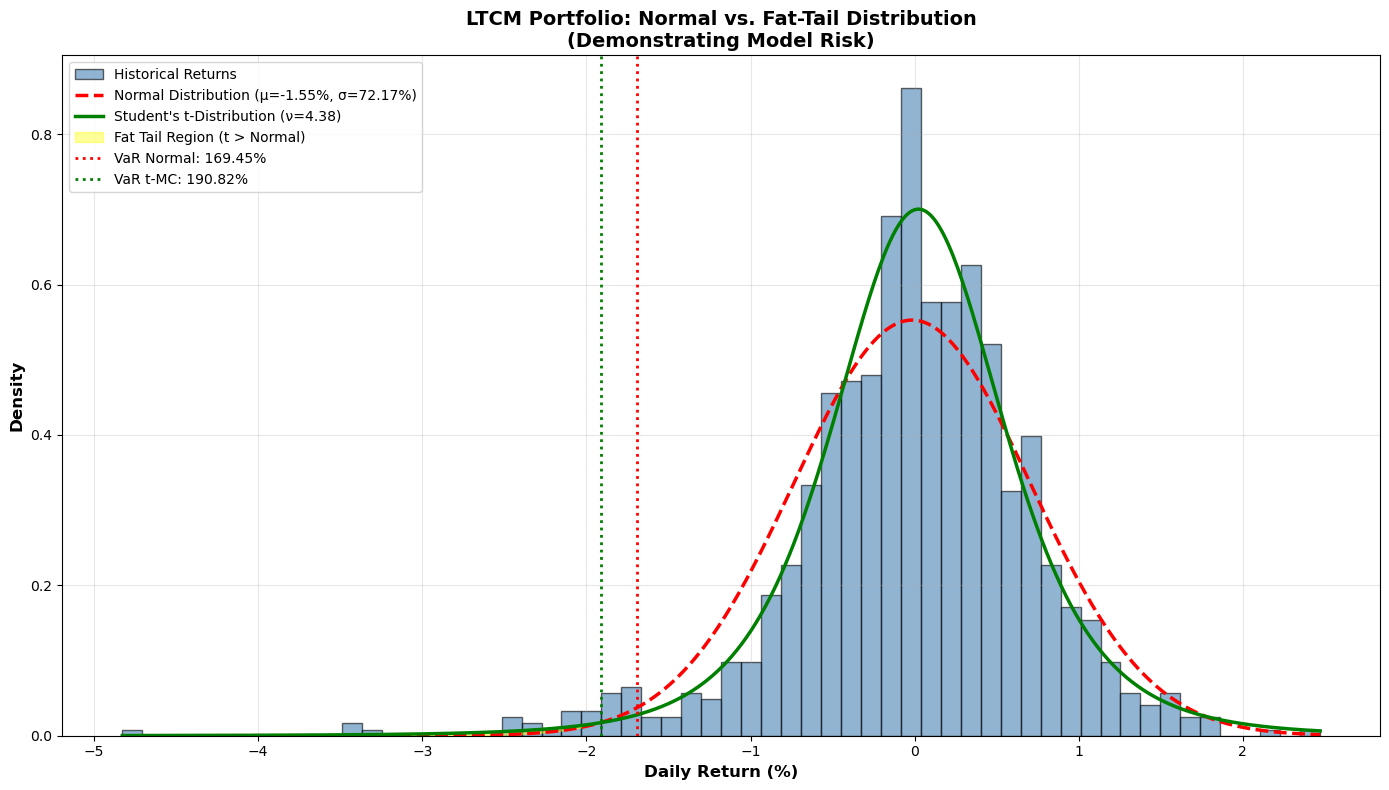

Figure saved: figs/distribution_comparison.png


In [9]:
# Visualization 1: Distribution Overlap showing Fat Tails
fig, ax = plt.subplots(figsize=(14, 8))

# Histogram of actual returns
ax.hist(returns_data, bins=60, density=True, alpha=0.6, color='steelblue', 
        edgecolor='black', label='Historical Returns')

# Generate x-axis for density curves
x_range = np.linspace(returns_data.min(), returns_data.max(), 500)

# Overlay Normal distribution
normal_density = stats.norm.pdf(x_range, mu, sigma)
ax.plot(x_range, normal_density, 'r--', linewidth=2.5, 
        label=f'Normal Distribution (μ={mu*100:.2f}%, σ={sigma*100:.2f}%)')

# Overlay Student's t-distribution
t_density = stats.t.pdf(x_range, nu, loc=loc, scale=scale)
ax.plot(x_range, t_density, 'g-', linewidth=2.5, 
        label=f"Student's t-Distribution (ν={nu:.2f})")

# Highlight the fat tail region
tail_threshold = np.percentile(returns_data, 5)
x_tail = x_range[x_range <= tail_threshold]
t_tail = stats.t.pdf(x_tail, nu, loc=loc, scale=scale)
normal_tail = stats.norm.pdf(x_tail, mu, sigma)
ax.fill_between(x_tail, normal_tail, t_tail, where=(t_tail > normal_tail), 
                color='yellow', alpha=0.4, label='Fat Tail Region (t > Normal)')

# Add VaR lines
ax.axvline(-VaR_normal, color='red', linestyle=':', linewidth=2, 
           label=f'VaR Normal: {VaR_normal*100:.2f}%')
ax.axvline(-VaR_t_mc, color='green', linestyle=':', linewidth=2, 
           label=f'VaR t-MC: {VaR_t_mc*100:.2f}%')

ax.set_xlabel('Daily Return (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('LTCM Portfolio: Normal vs. Fat-Tail Distribution\n(Demonstrating Model Risk)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/distribution_comparison.png")

### Risk Metric Comparison Over Time

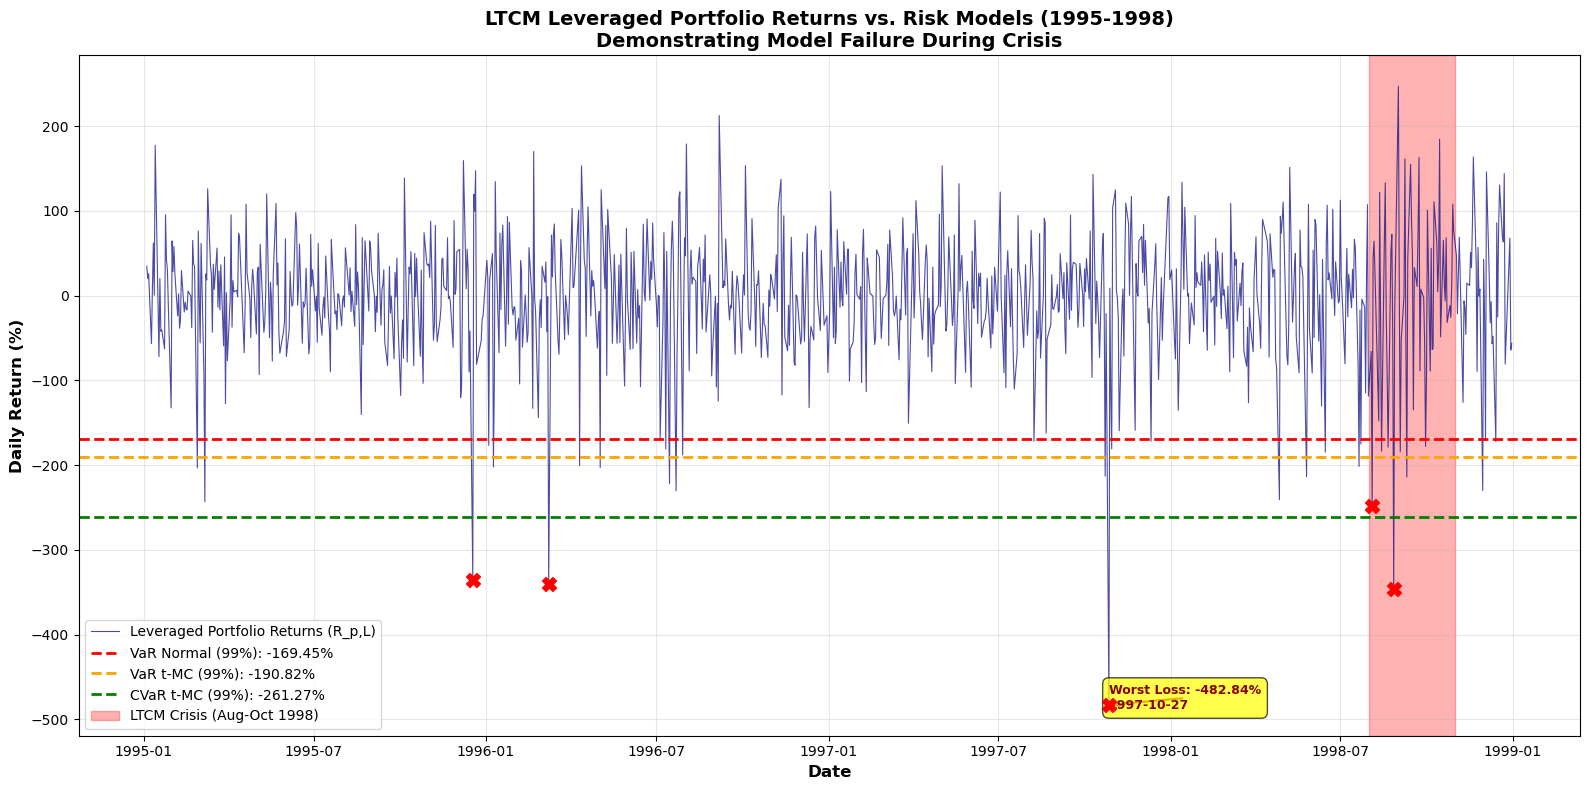

Figure saved: figs/risk_metrics_time_series.png


In [10]:
# Visualization 2: Portfolio Returns with VaR Levels Over Time
fig, ax = plt.subplots(figsize=(16, 8))

# Plot leveraged portfolio returns
returns_pct = df_returns['R_p_L'] * 100
ax.plot(df_returns.index, returns_pct, color='navy', linewidth=0.8, 
        label='Leveraged Portfolio Returns (R_p,L)', alpha=0.7)

# Add VaR threshold lines
ax.axhline(-VaR_normal*100, color='red', linestyle='--', linewidth=2, 
           label=f'VaR Normal (99%): -{VaR_normal*100:.2f}%')
ax.axhline(-VaR_t_mc*100, color='orange', linestyle='--', linewidth=2, 
           label=f'VaR t-MC (99%): -{VaR_t_mc*100:.2f}%')
ax.axhline(-CVaR_t_mc*100, color='green', linestyle='--', linewidth=2, 
           label=f'CVaR t-MC (99%): -{CVaR_t_mc*100:.2f}%')

# Highlight the 1998 crisis period (Russia default in August)
crisis_start = pd.Timestamp('1998-08-01')
crisis_end = pd.Timestamp('1998-10-31')
ax.axvspan(crisis_start, crisis_end, alpha=0.3, color='red', 
           label='LTCM Crisis (Aug-Oct 1998)')

# Mark worst losses
worst_returns = returns_pct.nsmallest(5)
for date, ret in worst_returns.items():
    ax.scatter(date, ret, color='red', s=100, zorder=5, marker='X')
    if ret == returns_pct.min():
        ax.annotate(f'Worst Loss: {ret:.2f}%\n{date.strftime("%Y-%m-%d")}', 
                   xy=(date, ret), xytext=(date, ret-5),
                   fontsize=9, fontweight='bold', color='darkred',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='darkred', lw=1.5))

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Daily Return (%)', fontsize=12, fontweight='bold')
ax.set_title('LTCM Leveraged Portfolio Returns vs. Risk Models (1995-1998)\n' + 
             'Demonstrating Model Failure During Crisis', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/risk_metrics_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/risk_metrics_time_series.png")

### Stress Scenario Analysis (Spread Divergence)

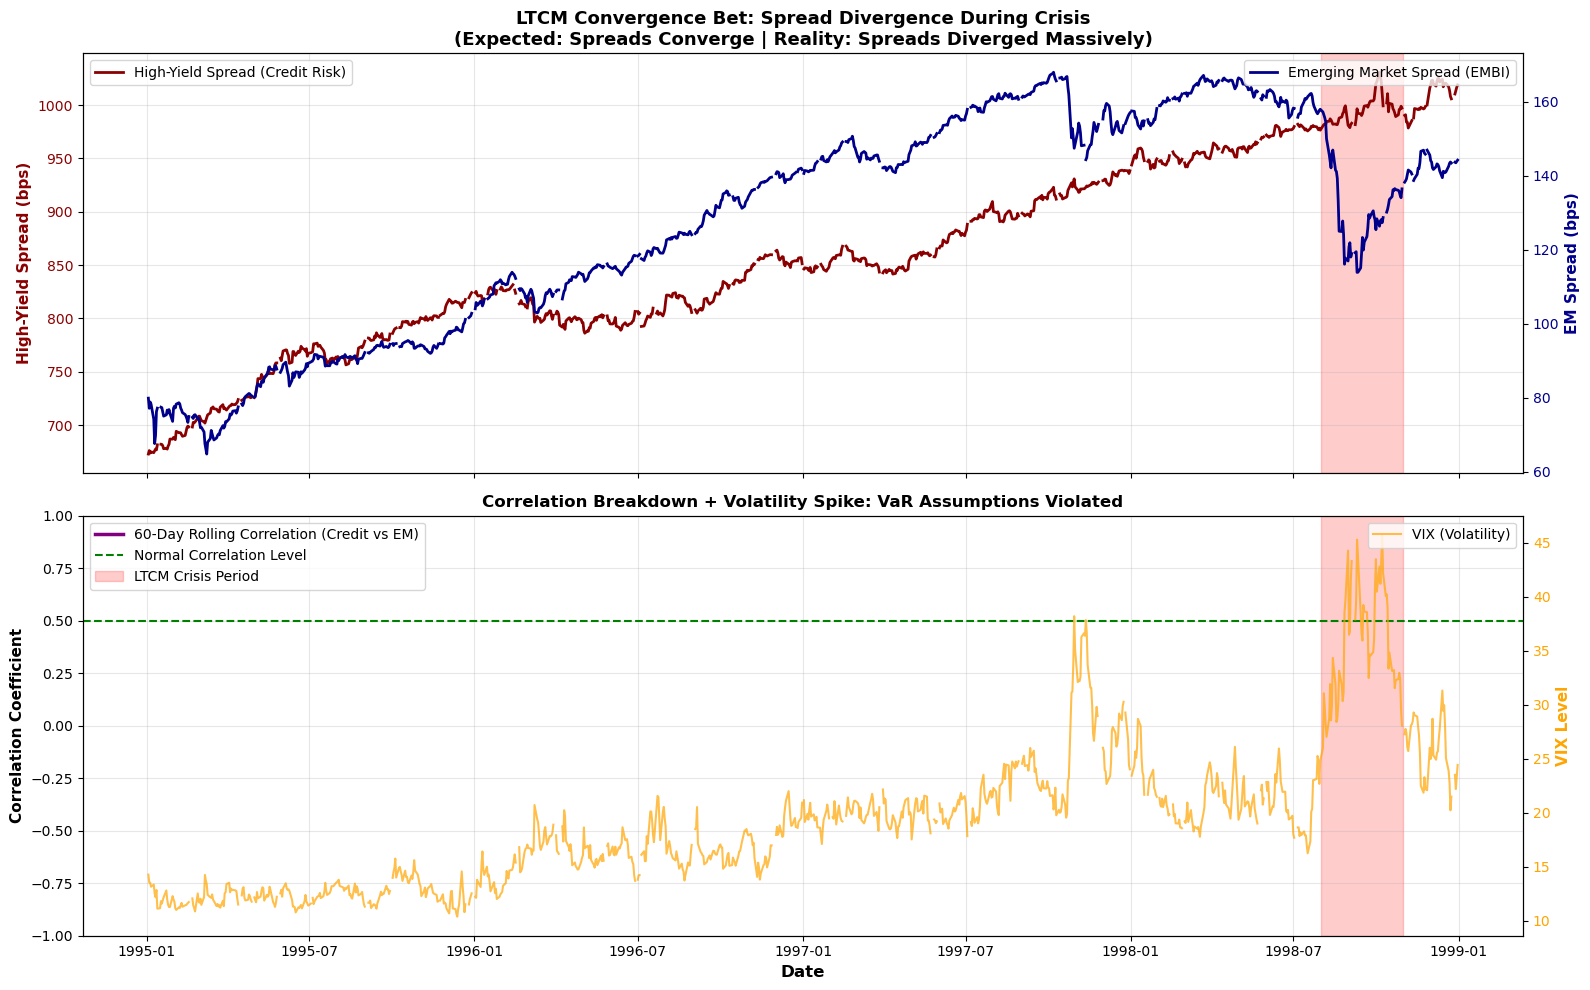

Figure saved: figs/spread_divergence_analysis.png


In [11]:
# Visualization 3: Spread Divergence (The LTCM Bet Failure)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Panel 1: Credit Spread and Emerging Market Spread
ax1.plot(df_ltcm.index, df_ltcm['Credit Spread Risk'], 
         color='darkred', linewidth=2, label='High-Yield Spread (Credit Risk)')
ax1_twin = ax1.twinx()
ax1_twin.plot(df_ltcm.index, df_ltcm['JPMorgan EMBI Global Diversifie'], 
              color='darkblue', linewidth=2, label='Emerging Market Spread (EMBI)')

# Highlight crisis period
crisis_start = pd.Timestamp('1998-08-01')
crisis_end = pd.Timestamp('1998-10-31')
ax1.axvspan(crisis_start, crisis_end, alpha=0.2, color='red')

ax1.set_ylabel('High-Yield Spread (bps)', fontsize=11, fontweight='bold', color='darkred')
ax1_twin.set_ylabel('EM Spread (bps)', fontsize=11, fontweight='bold', color='darkblue')
ax1.set_title('LTCM Convergence Bet: Spread Divergence During Crisis\n' +
              '(Expected: Spreads Converge | Reality: Spreads Diverged Massively)', 
              fontsize=13, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='darkred')
ax1_twin.tick_params(axis='y', labelcolor='darkblue')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=10)
ax1_twin.legend(loc='upper right', fontsize=10)

# Panel 2: Correlation breakdown and volatility spike
# Calculate rolling correlation (60-day window)
roll_corr = df_ltcm['Credit Spread Risk'].rolling(60).corr(df_ltcm['JPMorgan EMBI Global Diversifie'])

ax2.plot(df_ltcm.index, roll_corr, color='purple', linewidth=2.5, 
         label='60-Day Rolling Correlation (Credit vs EM)')
ax2.axhline(0.5, color='green', linestyle='--', linewidth=1.5, 
            label='Normal Correlation Level')
ax2.axvspan(crisis_start, crisis_end, alpha=0.2, color='red', 
            label='LTCM Crisis Period')

# Add volatility on secondary axis
ax2_twin = ax2.twinx()
ax2_twin.plot(df_ltcm.index, df_ltcm['Volatility Index'], 
              color='orange', linewidth=1.5, alpha=0.7, label='VIX (Volatility)')
ax2_twin.set_ylabel('VIX Level', fontsize=11, fontweight='bold', color='orange')
ax2_twin.tick_params(axis='y', labelcolor='orange')

# Mark correlation breakdown
crisis_corr = roll_corr[crisis_start:crisis_end]
if not crisis_corr.empty and not crisis_corr.isna().all():
    min_corr = crisis_corr.min()
    min_corr_date = crisis_corr.idxmin()
    ax2.scatter(min_corr_date, min_corr, color='red', s=200, zorder=5, marker='X')
    ax2.annotate(f'Correlation Breakdown\n{min_corr:.3f} on {min_corr_date.strftime("%Y-%m-%d")}', 
                xy=(min_corr_date, min_corr), xytext=(min_corr_date, min_corr-0.3),
                fontsize=9, fontweight='bold', color='darkred',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='darkred', lw=1.5))

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Correlation Coefficient', fontsize=11, fontweight='bold')
ax2.set_title('Correlation Breakdown + Volatility Spike: VaR Assumptions Violated', 
              fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2_twin.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([-1, 1])

plt.tight_layout()
plt.savefig('figs/spread_divergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/spread_divergence_analysis.png")

### VaR Comparison Bar Chart

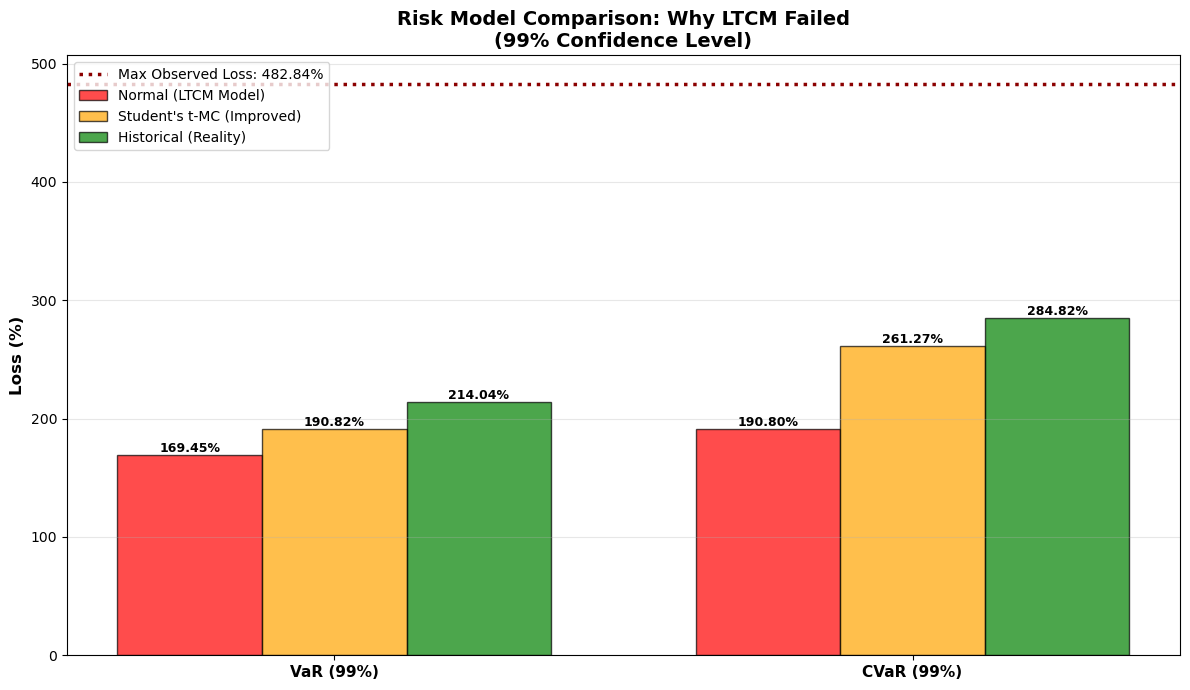

Figure saved: figs/var_comparison_bars.png


In [12]:
# Visualization 4: Bar Chart Comparison of Risk Metrics
fig, ax = plt.subplots(figsize=(12, 7))

metrics = ['VaR (99%)', 'CVaR (99%)']
normal_vals = [VaR_normal*100, CVaR_normal*100]
t_mc_vals = [VaR_t_mc*100, CVaR_t_mc*100]
hist_vals = [VaR_hist*100, CVaR_hist*100]

x = np.arange(len(metrics))
width = 0.25

bars1 = ax.bar(x - width, normal_vals, width, label='Normal (LTCM Model)', 
               color='red', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x, t_mc_vals, width, label='Student\'s t-MC (Improved)', 
               color='orange', alpha=0.7, edgecolor='black')
bars3 = ax.bar(x + width, hist_vals, width, label='Historical (Reality)', 
               color='green', alpha=0.7, edgecolor='black')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add maximum loss reference line
ax.axhline(max_loss*100, color='darkred', linestyle=':', linewidth=2.5, 
           label=f'Max Observed Loss: {max_loss*100:.2f}%')

ax.set_ylabel('Loss (%)', fontsize=12, fontweight='bold')
ax.set_title('Risk Model Comparison: Why LTCM Failed\n(99% Confidence Level)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figs/var_comparison_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/var_comparison_bars.png")

### Rolling Risk Metrics

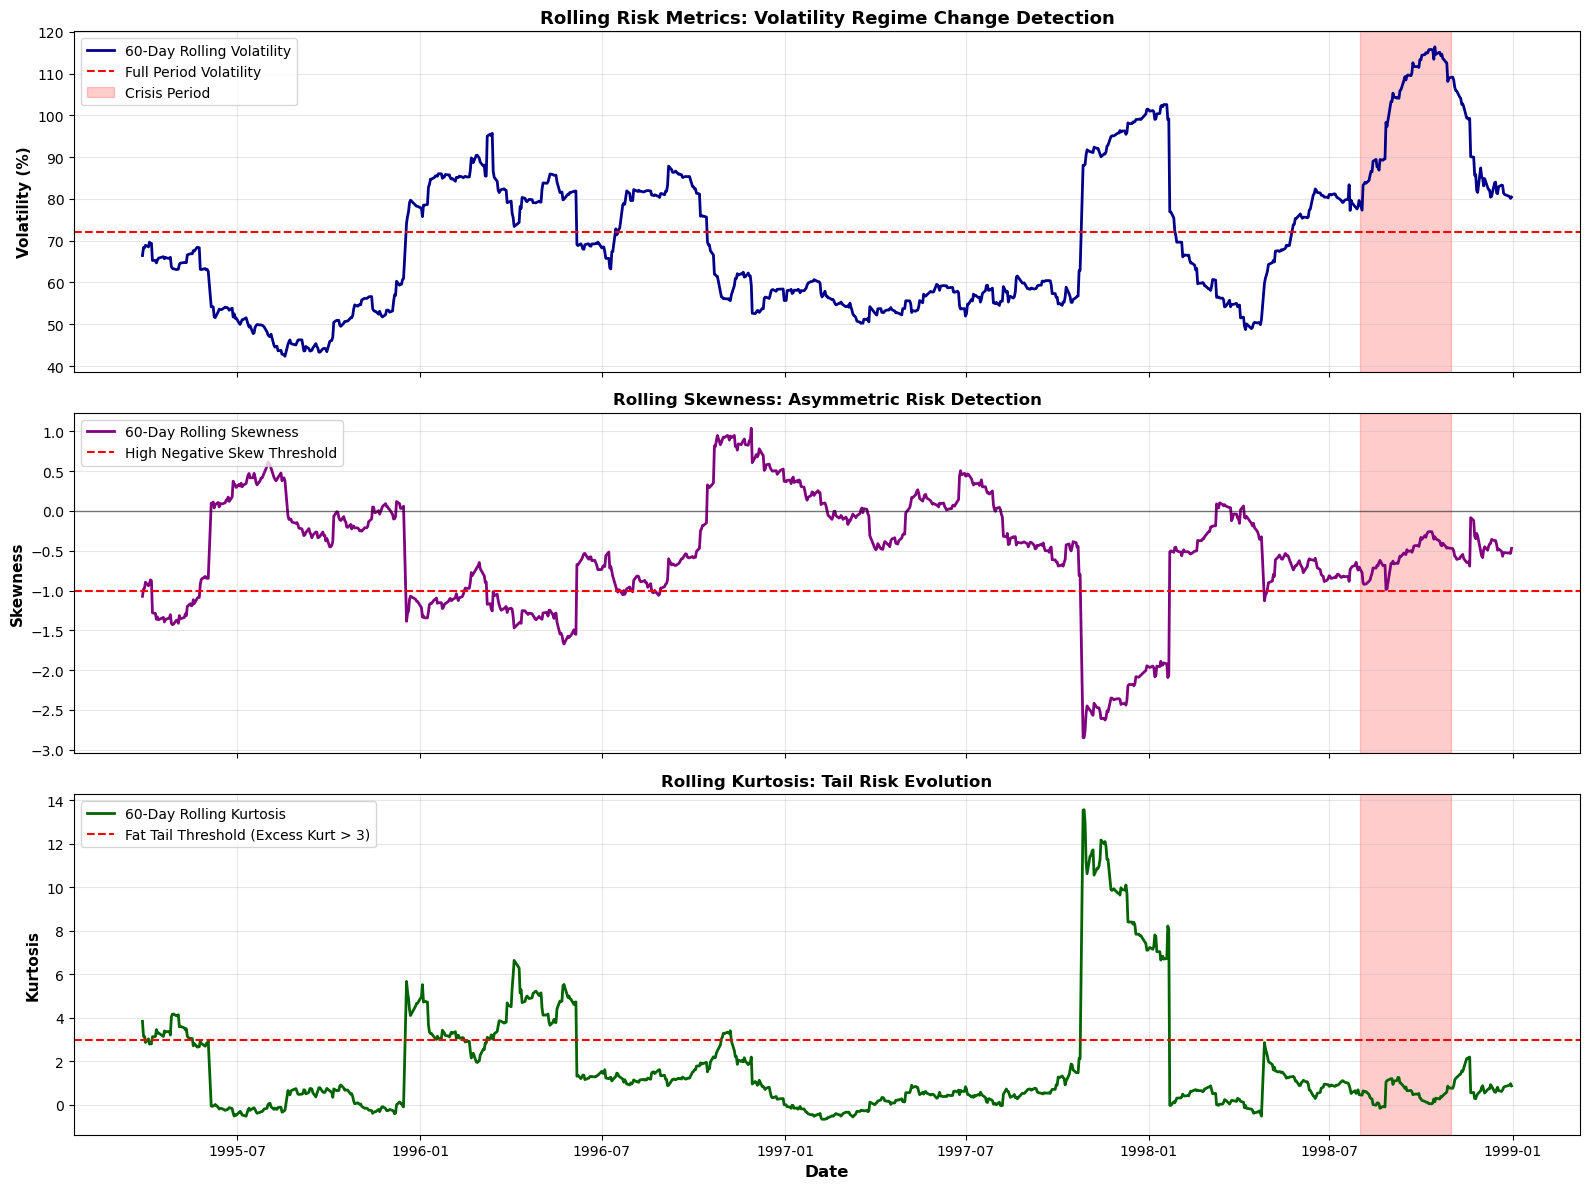

Figure saved: figs/rolling_risk_metrics.png


In [13]:
# Visualization 5: Rolling Volatility and VaR
window = 60  # 60-day rolling window

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Panel 1: Rolling Volatility
rolling_vol = df_returns['R_p_L'].rolling(window).std() * 100
ax1.plot(df_returns.index, rolling_vol, color='darkblue', linewidth=2, label=f'{window}-Day Rolling Volatility')
ax1.axhline(sigma*100, color='red', linestyle='--', linewidth=1.5, label='Full Period Volatility')
ax1.axvspan(crisis_start, crisis_end, alpha=0.2, color='red', label='Crisis Period')
ax1.set_ylabel('Volatility (%)', fontsize=11, fontweight='bold')
ax1.set_title('Rolling Risk Metrics: Volatility Regime Change Detection', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Panel 2: Rolling Skewness
rolling_skew = df_returns['R_p_L'].rolling(window).skew()
ax2.plot(df_returns.index, rolling_skew, color='purple', linewidth=2, label=f'{window}-Day Rolling Skewness')
ax2.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.axhline(-1, color='red', linestyle='--', linewidth=1.5, label='High Negative Skew Threshold')
ax2.axvspan(crisis_start, crisis_end, alpha=0.2, color='red')
ax2.set_ylabel('Skewness', fontsize=11, fontweight='bold')
ax2.set_title('Rolling Skewness: Asymmetric Risk Detection', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Panel 3: Rolling Kurtosis
rolling_kurt = df_returns['R_p_L'].rolling(window).kurt()
ax3.plot(df_returns.index, rolling_kurt, color='darkgreen', linewidth=2, label=f'{window}-Day Rolling Kurtosis')
ax3.axhline(3, color='red', linestyle='--', linewidth=1.5, label='Fat Tail Threshold (Excess Kurt > 3)')
ax3.axvspan(crisis_start, crisis_end, alpha=0.2, color='red')
ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3.set_ylabel('Kurtosis', fontsize=11, fontweight='bold')
ax3.set_title('Rolling Kurtosis: Tail Risk Evolution', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/rolling_risk_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/rolling_risk_metrics.png")

### Drawdown Analysis

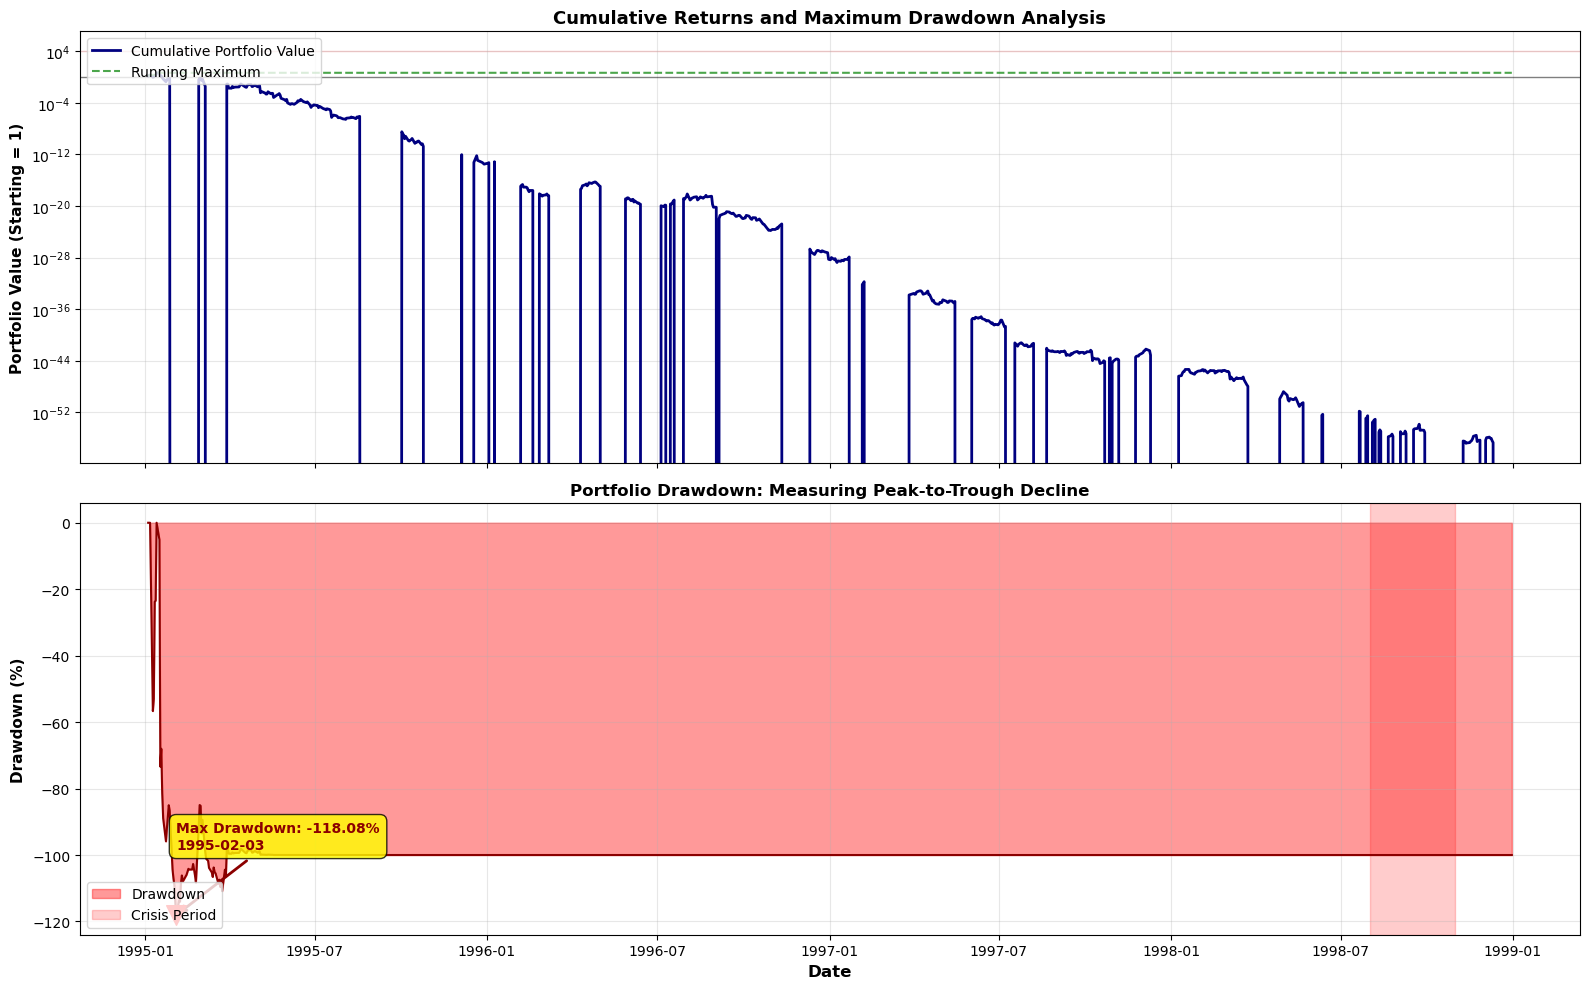

Figure saved: figs/drawdown_analysis.png
Maximum Drawdown: -118.08%
Occurred on: 1995-02-03


In [14]:
# Visualization 6: Drawdown Analysis (Critical for Hedge Funds)
# Calculate cumulative returns
cumulative_returns = (1 + df_returns['R_p_L']).cumprod()
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Panel 1: Cumulative Returns with Running Maximum
ax1.plot(df_returns.index, cumulative_returns, color='navy', linewidth=2, label='Cumulative Portfolio Value')
ax1.plot(df_returns.index, running_max, color='green', linestyle='--', linewidth=1.5, 
         label='Running Maximum', alpha=0.7)
ax1.axhspan(crisis_start, crisis_end, alpha=0.2, color='red')
ax1.axhline(1, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax1.set_ylabel('Portfolio Value (Starting = 1)', fontsize=11, fontweight='bold')
ax1.set_title('Cumulative Returns and Maximum Drawdown Analysis', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Panel 2: Drawdown
ax2.fill_between(df_returns.index, drawdown, 0, color='red', alpha=0.4, label='Drawdown')
ax2.plot(df_returns.index, drawdown, color='darkred', linewidth=1.5)
ax2.axvspan(crisis_start, crisis_end, alpha=0.2, color='red', label='Crisis Period')

# Mark maximum drawdown
max_dd_idx = drawdown.idxmin()
max_dd_val = drawdown.min()
ax2.scatter(max_dd_idx, max_dd_val, color='red', s=200, zorder=5, marker='v')
ax2.annotate(f'Max Drawdown: {max_dd_val:.2f}%\n{max_dd_idx.strftime("%Y-%m-%d")}', 
            xy=(max_dd_idx, max_dd_val), xytext=(max_dd_idx, max_dd_val+20),
            fontsize=10, fontweight='bold', color='darkred',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='darkred', lw=2))

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
ax2.set_title('Portfolio Drawdown: Measuring Peak-to-Trough Decline', fontsize=12, fontweight='bold')
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/drawdown_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/drawdown_analysis.png")
print(f"Maximum Drawdown: {max_dd_val:.2f}%")
print(f"Occurred on: {max_dd_idx.strftime('%Y-%m-%d')}")

### Q-Q Plot: Testing Normality Assumption

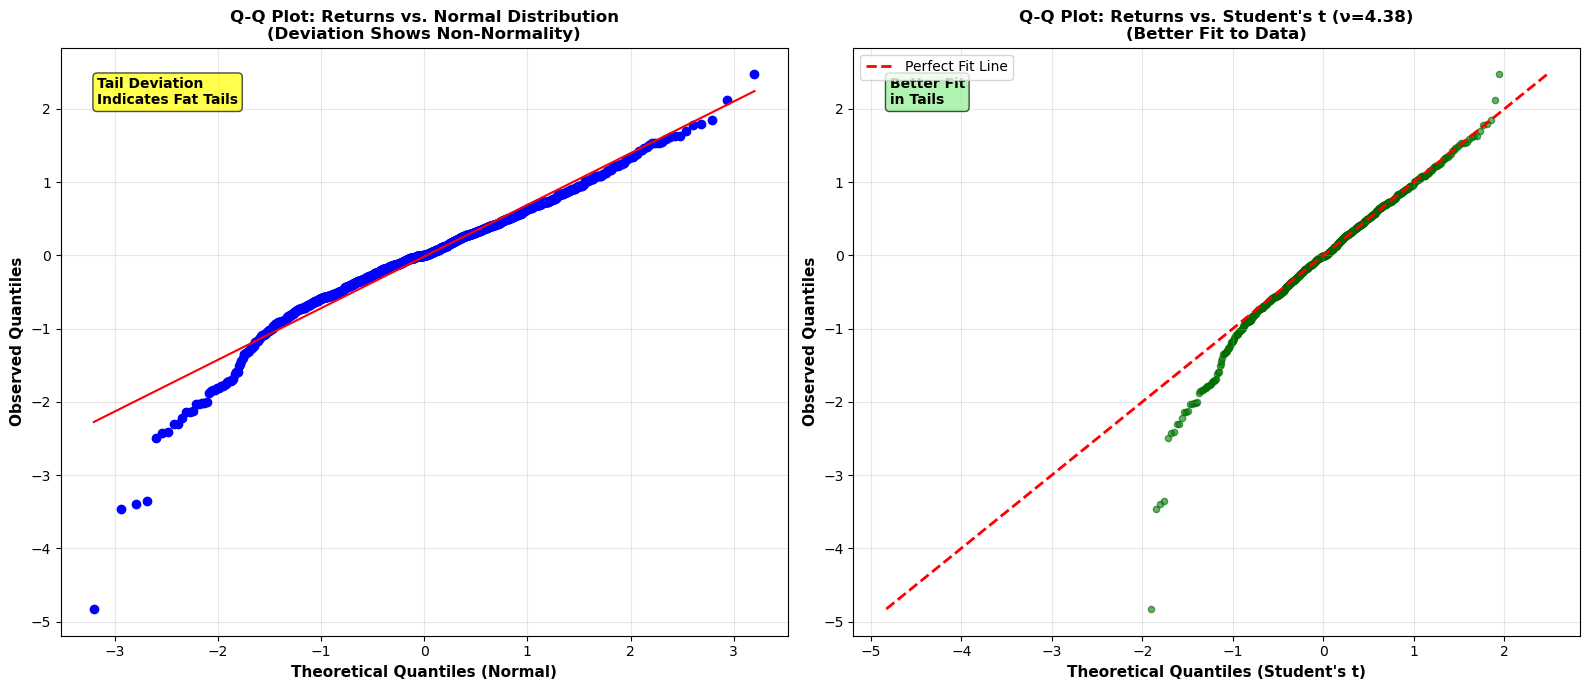

Figure saved: figs/qq_plots.png


In [15]:
# Visualization: Q-Q Plots (Normal vs. Student's t)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Q-Q Plot vs Normal Distribution
stats.probplot(returns_data, dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot: Returns vs. Normal Distribution\n(Deviation Shows Non-Normality)', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Theoretical Quantiles (Normal)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Observed Quantiles', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add annotation for tail deviation
ax1.text(0.05, 0.95, 'Tail Deviation\nIndicates Fat Tails', 
         transform=ax1.transAxes, fontsize=10, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Q-Q Plot vs Student's t Distribution
# Generate t-distribution quantiles
sorted_data = np.sort(returns_data)
theoretical_quantiles = stats.t.ppf(np.linspace(0.01, 0.99, len(sorted_data)), nu, loc=loc, scale=scale)

ax2.scatter(theoretical_quantiles, sorted_data, alpha=0.6, s=20, color='green', edgecolors='darkgreen')
min_val = min(theoretical_quantiles.min(), sorted_data.min())
max_val = max(theoretical_quantiles.max(), sorted_data.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit Line')
ax2.set_title(f'Q-Q Plot: Returns vs. Student\'s t (ν={nu:.2f})\n(Better Fit to Data)', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Theoretical Quantiles (Student\'s t)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Observed Quantiles', fontsize=11, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Add annotation for better fit
ax2.text(0.05, 0.95, 'Better Fit\nin Tails', 
         transform=ax2.transAxes, fontsize=10, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.savefig('figs/qq_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/qq_plots.png")

### VaR Backtesting: Model Validation

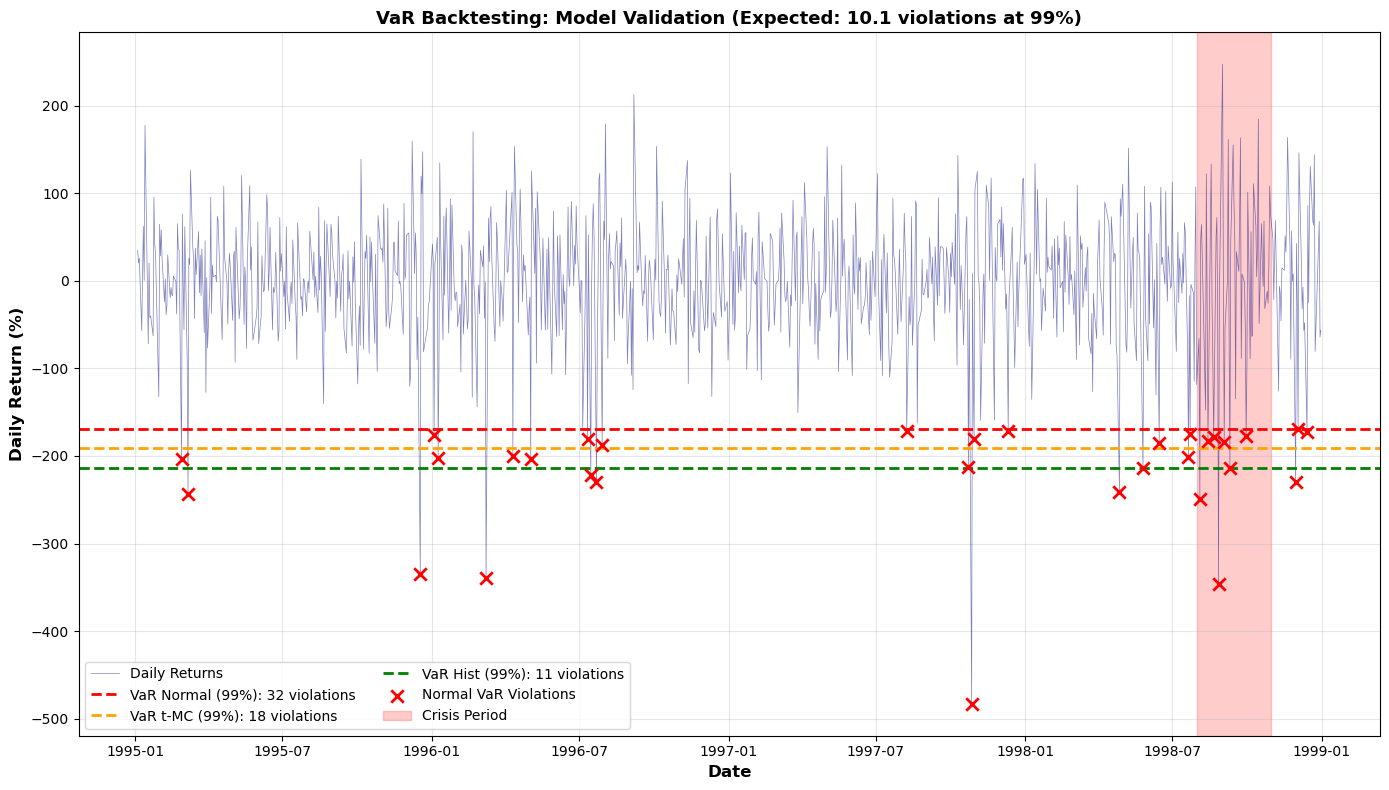

Figure saved: figs/var_backtesting.png

VaR Backtesting Results (99% confidence, expected ≈ 10 violations):
  Normal VaR: 32 violations (3.17%)
  t-MC VaR: 18 violations (1.78%)
  Historical VaR: 11 violations (1.09%)


In [16]:
# Visualization: VaR Backtesting - Violations Analysis
# Count VaR violations (when losses exceed VaR)
violations_normal = (df_returns['R_p_L'] < -VaR_normal).sum()
violations_t_mc = (df_returns['R_p_L'] < -VaR_t_mc).sum()
violations_hist = (df_returns['R_p_L'] < -VaR_hist).sum()

expected_violations = len(df_returns) * (1 - alpha)

fig, ax = plt.subplots(figsize=(14, 8))

# Plot returns
returns_pct = df_returns['R_p_L'] * 100
ax.plot(df_returns.index, returns_pct, color='navy', linewidth=0.5, alpha=0.5, label='Daily Returns')

# Add VaR thresholds
ax.axhline(-VaR_normal*100, color='red', linestyle='--', linewidth=2, 
           label=f'VaR Normal (99%): {violations_normal} violations')
ax.axhline(-VaR_t_mc*100, color='orange', linestyle='--', linewidth=2, 
           label=f'VaR t-MC (99%): {violations_t_mc} violations')
ax.axhline(-VaR_hist*100, color='green', linestyle='--', linewidth=2, 
           label=f'VaR Hist (99%): {violations_hist} violations')

# Highlight violations for Normal VaR
violations_normal_dates = df_returns[df_returns['R_p_L'] < -VaR_normal].index
violations_normal_values = (df_returns.loc[violations_normal_dates, 'R_p_L'] * 100).values
ax.scatter(violations_normal_dates, violations_normal_values, color='red', s=80, 
           zorder=5, marker='x', linewidths=2, label=f'Normal VaR Violations')

# Highlight crisis period
ax.axvspan(crisis_start, crisis_end, alpha=0.2, color='red', label='Crisis Period')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Daily Return (%)', fontsize=12, fontweight='bold')
ax.set_title(f'VaR Backtesting: Model Validation (Expected: {expected_violations:.1f} violations at 99%)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='lower left', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/var_backtesting.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/var_backtesting.png")
print(f"\nVaR Backtesting Results (99% confidence, expected ≈ {expected_violations:.0f} violations):")
print(f"  Normal VaR: {violations_normal} violations ({violations_normal/len(df_returns)*100:.2f}%)")
print(f"  t-MC VaR: {violations_t_mc} violations ({violations_t_mc/len(df_returns)*100:.2f}%)")
print(f"  Historical VaR: {violations_hist} violations ({violations_hist/len(df_returns)*100:.2f}%)")

### Correlation Heatmap: Asset Relationships

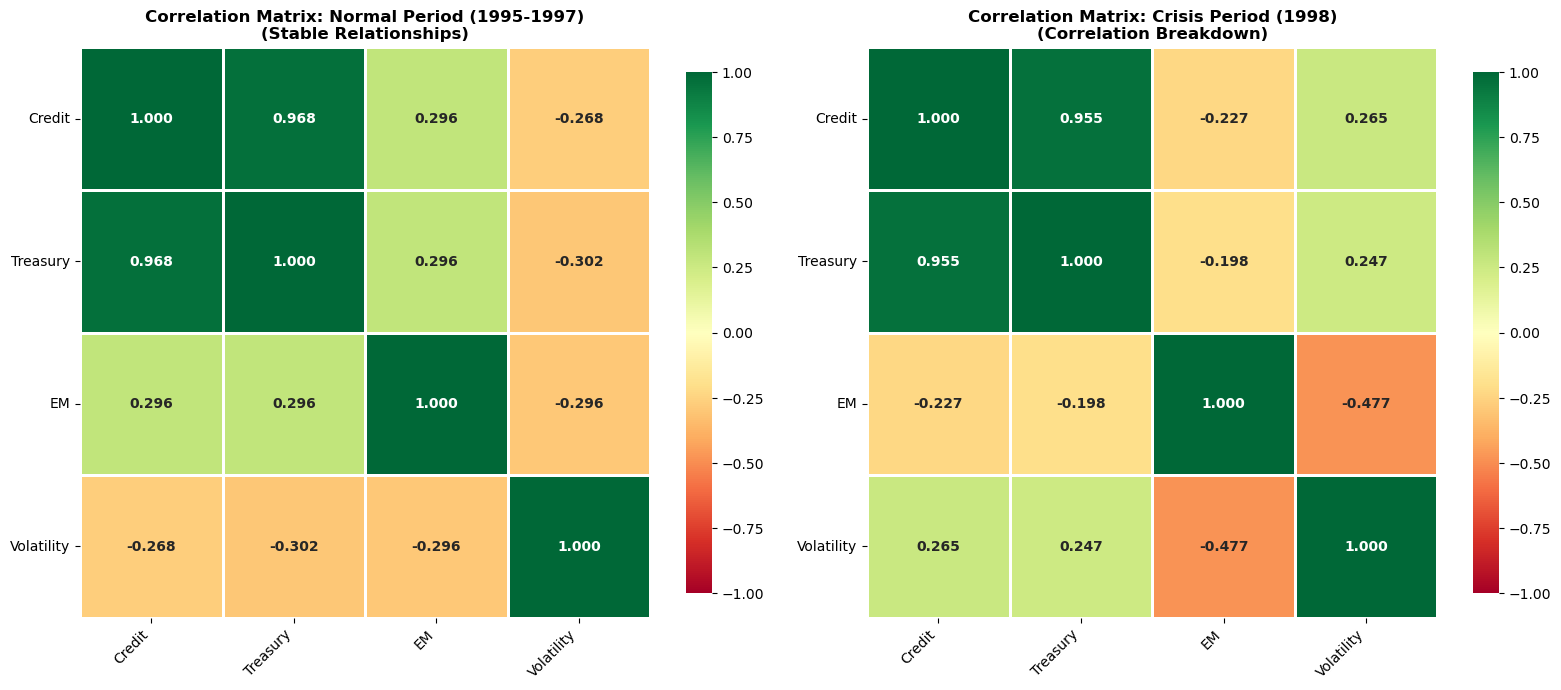

Figure saved: figs/correlation_heatmap.png

Largest Correlation Changes (Normal → Crisis):
  R_credit ↔ R_em: -0.524
  R_credit ↔ R_vol: +0.533
  R_treasury ↔ R_em: -0.495
  R_treasury ↔ R_vol: +0.549


In [17]:
# Visualization 9: Correlation Matrix (Normal vs Crisis Period)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Correlation during normal period (pre-crisis: 1995-1997)
normal_period = (df_returns.index >= '1995-01-01') & (df_returns.index <= '1997-12-31')
corr_normal = df_returns.loc[normal_period, ['R_credit', 'R_treasury', 'R_em', 'R_vol']].corr()

# Correlation during crisis period (1998)
crisis_period = (df_returns.index >= '1998-01-01') & (df_returns.index <= '1998-12-31')
corr_crisis = df_returns.loc[crisis_period, ['R_credit', 'R_treasury', 'R_em', 'R_vol']].corr()

# Plot normal period
sns.heatmap(corr_normal, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax1, annot_kws={'fontsize': 10, 'fontweight': 'bold'})
ax1.set_title('Correlation Matrix: Normal Period (1995-1997)\n(Stable Relationships)', 
              fontsize=12, fontweight='bold')
ax1.set_xticklabels(['Credit', 'Treasury', 'EM', 'Volatility'], rotation=45, ha='right', fontsize=10)
ax1.set_yticklabels(['Credit', 'Treasury', 'EM', 'Volatility'], rotation=0, fontsize=10)

# Plot crisis period
sns.heatmap(corr_crisis, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax2, annot_kws={'fontsize': 10, 'fontweight': 'bold'})
ax2.set_title('Correlation Matrix: Crisis Period (1998)\n(Correlation Breakdown)', 
              fontsize=12, fontweight='bold')
ax2.set_xticklabels(['Credit', 'Treasury', 'EM', 'Volatility'], rotation=45, ha='right', fontsize=10)
ax2.set_yticklabels(['Credit', 'Treasury', 'EM', 'Volatility'], rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig('figs/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/correlation_heatmap.png")

# Calculate correlation changes
corr_change = corr_crisis - corr_normal
print("\nLargest Correlation Changes (Normal → Crisis):")
for i in range(len(corr_change)):
    for j in range(i+1, len(corr_change)):
        change = corr_change.iloc[i, j]
        if abs(change) > 0.2:
            print(f"  {corr_change.index[i]} ↔ {corr_change.columns[j]}: {change:+.3f}")

### Monte Carlo Simulation Paths

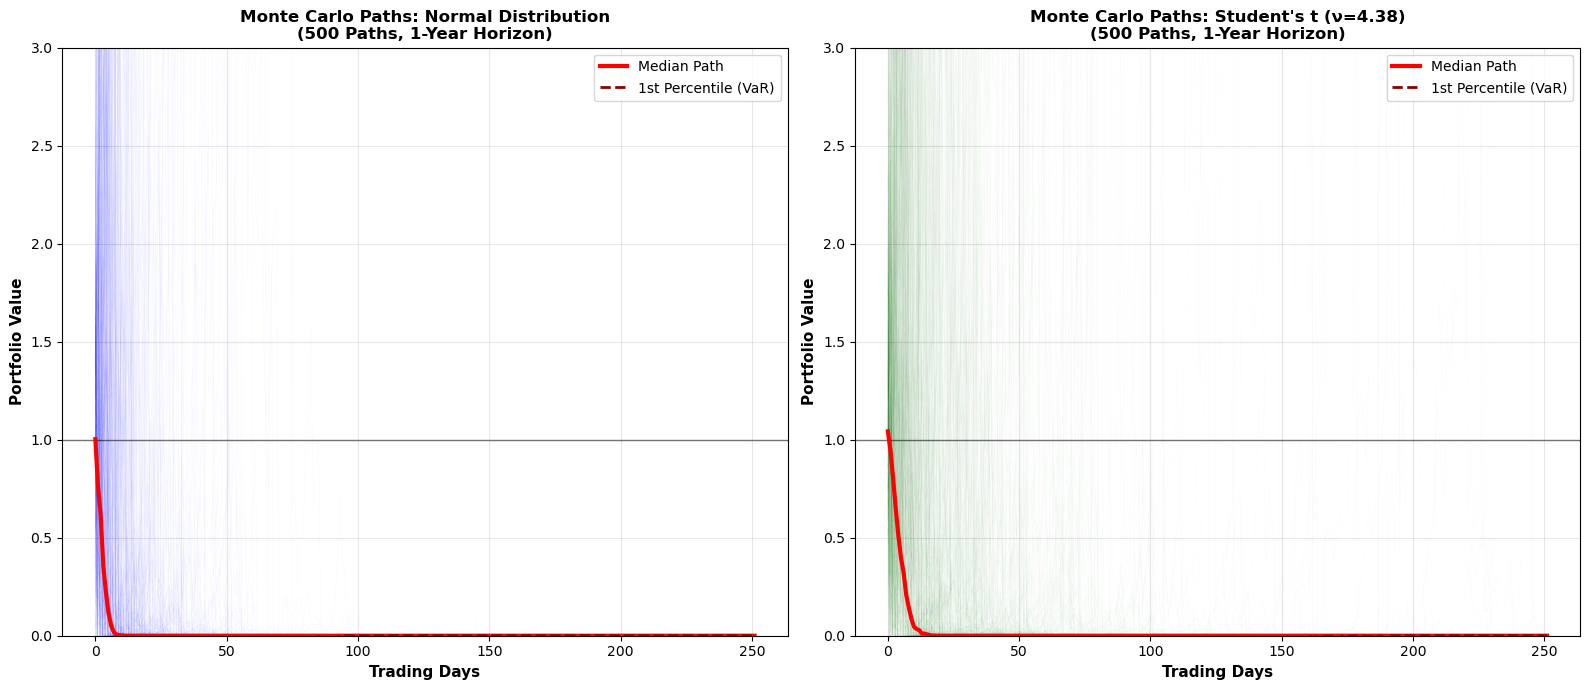

Figure saved: figs/monte_carlo_paths.png

1-Year Projections:
  Normal: Median = 0.000, VaR(99%) = -0.000
  Student's t: Median = 0.000, VaR(99%) = -0.000


In [18]:
# Visualization 10: Monte Carlo Simulation Paths Visualization
np.random.seed(42)
n_paths = 500
n_days = 252  # 1 year

# Generate paths using both Normal and Student's t
paths_normal = np.zeros((n_days, n_paths))
paths_t = np.zeros((n_days, n_paths))

for i in range(n_paths):
    # Normal distribution paths
    daily_returns_normal = np.random.normal(mu, sigma, n_days)
    paths_normal[:, i] = (1 + daily_returns_normal).cumprod()
    
    # Student's t distribution paths
    daily_returns_t = stats.t.rvs(nu, loc=loc, scale=scale, size=n_days)
    paths_t[:, i] = (1 + daily_returns_t).cumprod()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot Normal distribution paths
for i in range(n_paths):
    ax1.plot(range(n_days), paths_normal[:, i], color='blue', alpha=0.02, linewidth=0.5)
ax1.plot(range(n_days), np.median(paths_normal, axis=1), color='red', linewidth=3, 
         label='Median Path', zorder=5)
ax1.plot(range(n_days), np.percentile(paths_normal, 1, axis=1), color='darkred', 
         linewidth=2, linestyle='--', label='1st Percentile (VaR)', zorder=5)
ax1.axhline(1, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax1.set_xlabel('Trading Days', fontsize=11, fontweight='bold')
ax1.set_ylabel('Portfolio Value', fontsize=11, fontweight='bold')
ax1.set_title(f'Monte Carlo Paths: Normal Distribution\n({n_paths} Paths, 1-Year Horizon)', 
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 3])

# Plot Student's t distribution paths
for i in range(n_paths):
    ax2.plot(range(n_days), paths_t[:, i], color='green', alpha=0.02, linewidth=0.5)
ax2.plot(range(n_days), np.median(paths_t, axis=1), color='red', linewidth=3, 
         label='Median Path', zorder=5)
ax2.plot(range(n_days), np.percentile(paths_t, 1, axis=1), color='darkred', 
         linewidth=2, linestyle='--', label='1st Percentile (VaR)', zorder=5)
ax2.axhline(1, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.set_xlabel('Trading Days', fontsize=11, fontweight='bold')
ax2.set_ylabel('Portfolio Value', fontsize=11, fontweight='bold')
ax2.set_title(f'Monte Carlo Paths: Student\'s t (ν={nu:.2f})\n({n_paths} Paths, 1-Year Horizon)', 
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 3])

plt.tight_layout()
plt.savefig('figs/monte_carlo_paths.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/monte_carlo_paths.png")
print(f"\n1-Year Projections:")
print(f"  Normal: Median = {np.median(paths_normal[-1, :]):.3f}, VaR(99%) = {np.percentile(paths_normal[-1, :], 1):.3f}")
print(f"  Student's t: Median = {np.median(paths_t[-1, :]):.3f}, VaR(99%) = {np.percentile(paths_t[-1, :], 1):.3f}")

### Asset Component Performance Analysis

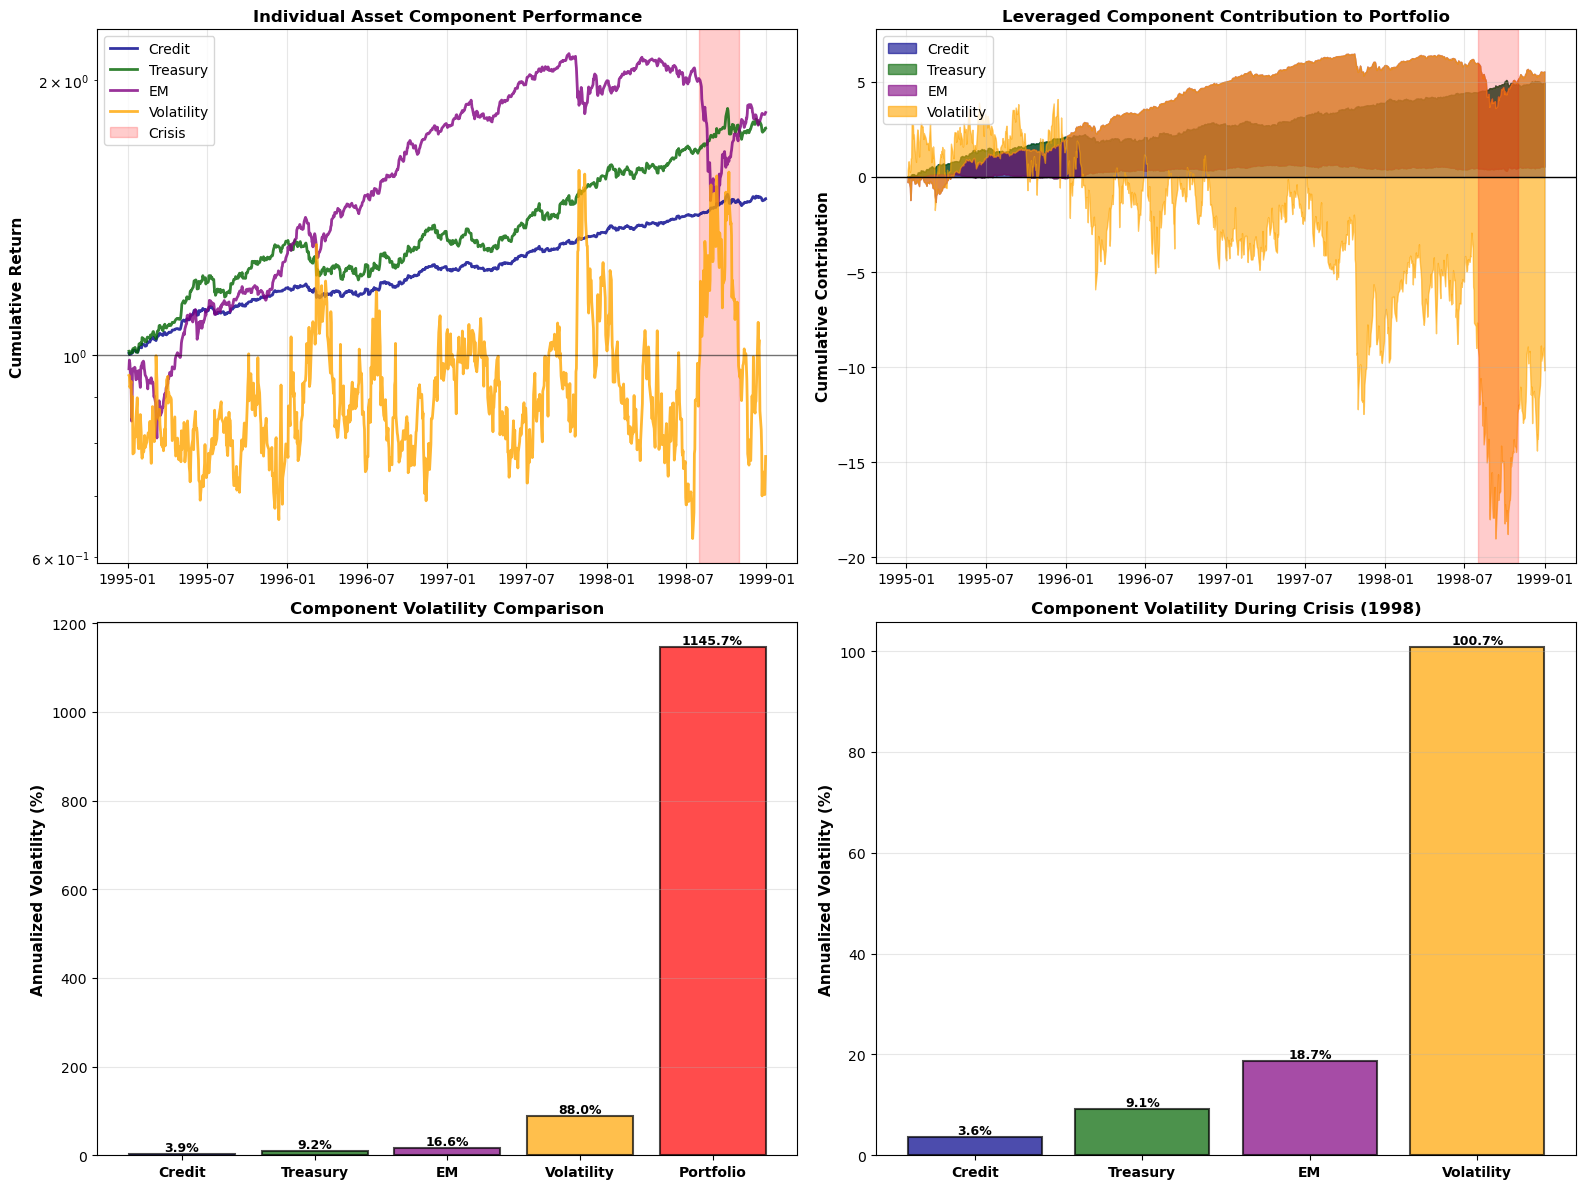

Figure saved: figs/component_analysis.png


In [19]:
# Visualization 11: Portfolio Component Contribution Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Individual Component Returns
component_names = ['Credit', 'Treasury', 'EM', 'Volatility']
component_returns = [df_returns['R_credit'], df_returns['R_treasury'], 
                    df_returns['R_em'], df_returns['R_vol']]
colors = ['darkblue', 'darkgreen', 'purple', 'orange']

for i, (name, returns, color) in enumerate(zip(component_names, component_returns, colors)):
    cumulative = (1 + returns).cumprod()
    ax1.plot(df_returns.index, cumulative, label=name, color=color, linewidth=2, alpha=0.8)

ax1.axvspan(crisis_start, crisis_end, alpha=0.2, color='red', label='Crisis')
ax1.axhline(1, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax1.set_ylabel('Cumulative Return', fontsize=11, fontweight='bold')
ax1.set_title('Individual Asset Component Performance', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Panel 2: Weighted Contribution to Portfolio
weighted_contributions = {
    'Credit': df_returns['R_credit'] * w_credit * L,
    'Treasury': df_returns['R_treasury'] * w_treasury * L,
    'EM': df_returns['R_em'] * w_em * L,
    'Volatility': df_returns['R_vol'] * w_vol * L
}

contribution_df = pd.DataFrame(weighted_contributions)
contribution_cumsum = contribution_df.cumsum()

ax2.fill_between(df_returns.index, 0, contribution_cumsum['Credit'], 
                 label='Credit', color='darkblue', alpha=0.6)
ax2.fill_between(df_returns.index, contribution_cumsum['Credit'], 
                 contribution_cumsum['Credit'] + contribution_cumsum['Treasury'],
                 label='Treasury', color='darkgreen', alpha=0.6)
ax2.fill_between(df_returns.index, 
                 contribution_cumsum['Credit'] + contribution_cumsum['Treasury'],
                 contribution_cumsum['Credit'] + contribution_cumsum['Treasury'] + contribution_cumsum['EM'],
                 label='EM', color='purple', alpha=0.6)
ax2.fill_between(df_returns.index, 
                 contribution_cumsum['Credit'] + contribution_cumsum['Treasury'] + contribution_cumsum['EM'],
                 contribution_cumsum.sum(axis=1),
                 label='Volatility', color='orange', alpha=0.6)

ax2.axvspan(crisis_start, crisis_end, alpha=0.2, color='red')
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.set_ylabel('Cumulative Contribution', fontsize=11, fontweight='bold')
ax2.set_title('Leveraged Component Contribution to Portfolio', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Panel 3: Volatility Comparison
vol_data = {name: returns.std()*100*np.sqrt(252) for name, returns in zip(component_names, component_returns)}
vol_data['Portfolio'] = df_returns['R_p_L'].std()*100*np.sqrt(252)

ax3.bar(range(len(vol_data)), list(vol_data.values()), color=['darkblue', 'darkgreen', 'purple', 'orange', 'red'],
        alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_xticks(range(len(vol_data)))
ax3.set_xticklabels(list(vol_data.keys()), fontsize=10, fontweight='bold')
ax3.set_ylabel('Annualized Volatility (%)', fontsize=11, fontweight='bold')
ax3.set_title('Component Volatility Comparison', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (key, val) in enumerate(vol_data.items()):
    ax3.text(i, val, f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Panel 4: Risk Contribution (during crisis)
crisis_returns = df_returns.loc[crisis_period]
crisis_vol = {
    'Credit': crisis_returns['R_credit'].std()*100*np.sqrt(252),
    'Treasury': crisis_returns['R_treasury'].std()*100*np.sqrt(252),
    'EM': crisis_returns['R_em'].std()*100*np.sqrt(252),
    'Volatility': crisis_returns['R_vol'].std()*100*np.sqrt(252)
}

ax4.bar(range(len(crisis_vol)), list(crisis_vol.values()), 
        color=['darkblue', 'darkgreen', 'purple', 'orange'],
        alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_xticks(range(len(crisis_vol)))
ax4.set_xticklabels(component_names, fontsize=10, fontweight='bold')
ax4.set_ylabel('Annualized Volatility (%)', fontsize=11, fontweight='bold')
ax4.set_title('Component Volatility During Crisis (1998)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (key, val) in enumerate(crisis_vol.items()):
    ax4.text(i, val, f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/component_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/component_analysis.png")

## final summary

In [20]:
# Final Summary Report
print("\n" + "="*80)
print("LTCM collapse analysis")
print("="*80)

print("\n PORTFOLIO CONFIGURATION:")
print(f"   • Strategy: Market-neutral convergence arbitrage")
print(f"   • Leverage: {L}x")
print(f"   • Period Analyzed: {df_ltcm.index.min().strftime('%Y-%m-%d')} to {df_ltcm.index.max().strftime('%Y-%m-%d')}")
print(f"   • Total Trading Days: {len(df_returns)}")

print("\n PORTFOLIO STATISTICS:")
print(f"   • Annualized Return: {(df_returns['R_p_L'].mean() * 252)*100:.2f}%")
print(f"   • Annualized Volatility: {(df_returns['R_p_L'].std() * np.sqrt(252))*100:.2f}%")
print(f"   • Sharpe Ratio: {(df_returns['R_p_L'].mean() / df_returns['R_p_L'].std()) * np.sqrt(252):.3f}")
print(f"   • Skewness: {df_returns['R_p_L'].skew():.3f} (Negative = Left tail)")
print(f"   • Excess Kurtosis: {df_returns['R_p_L'].kurtosis():.3f} (>3 = Fat tails)")

print("\n RISK MODEL COMPARISON (99% VaR):")
print(f"   1. Normal Distribution (LTCM's Approach):")
print(f"      └─ VaR: {VaR_normal*100:.2f}% | CVaR: {CVaR_normal*100:.2f}%")
print(f"   2. Student's t-Distribution (Fat-Tail Aware):")
print(f"      └─ VaR: {VaR_t_mc*100:.2f}% | CVaR: {CVaR_t_mc*100:.2f}%")
print(f"   3. Historical Simulation (Actual Data):")
print(f"      └─ VaR: {VaR_hist*100:.2f}% | CVaR: {CVaR_hist*100:.2f}%")

print("\n INSIGHT:")
underestimation = ((VaR_t_mc - VaR_normal) / VaR_normal * 100)
print(f"   • Normal VaR underestimated risk by {underestimation:.1f}%")
print(f"   • Actual maximum loss: {max_loss*100:.2f}%")
print(f"   • This loss was {(max_loss / VaR_normal):.1f}x larger than Normal VaR predicted!")



LTCM collapse analysis

 PORTFOLIO CONFIGURATION:
   • Strategy: Market-neutral convergence arbitrage
   • Leverage: 25x
   • Period Analyzed: 1995-01-02 to 1998-12-31
   • Total Trading Days: 1011

 PORTFOLIO STATISTICS:
   • Annualized Return: -390.58%
   • Annualized Volatility: 1145.69%
   • Sharpe Ratio: -0.341
   • Skewness: -0.904 (Negative = Left tail)
   • Excess Kurtosis: 3.756 (>3 = Fat tails)

 RISK MODEL COMPARISON (99% VaR):
   1. Normal Distribution (LTCM's Approach):
      └─ VaR: 169.45% | CVaR: 190.80%
   2. Student's t-Distribution (Fat-Tail Aware):
      └─ VaR: 190.82% | CVaR: 261.27%
   3. Historical Simulation (Actual Data):
      └─ VaR: 214.04% | CVaR: 284.82%

 INSIGHT:
   • Normal VaR underestimated risk by 12.6%
   • Actual maximum loss: 482.84%
   • This loss was 2.8x larger than Normal VaR predicted!
